In [1]:
#!pip install tensorflow==2.3.0

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


# 1 Data

## 1.1 Create Time Series Data

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp( 3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [4]:
time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [5]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

## 1.2 Split Data

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## 1.3 Windowed Dataset

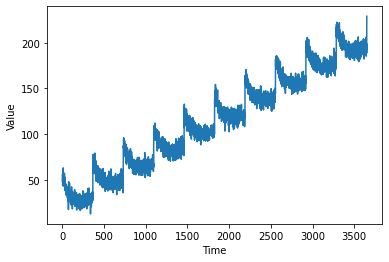

In [7]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

Desired output -- a chart that looks like this:

![Chart showing upward trend and seasonailty](http://www.laurencemoroney.com/wp-content/uploads/2019/07/plot1.png)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# 2 Model

## 2.1 Pick Learning Rate

### 2.1.1 Model

In [112]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(300, input_shape=[window_size], activation = "relu"),
    tf.keras.layers.Dense(250, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history = model.fit(dataset,epochs=100,verbose=0, callbacks=[lr_scheduler])


### 2.2 View per epoch Learning Rates vs Loss

(1e-06, 0.001, 0.0, 300.0)

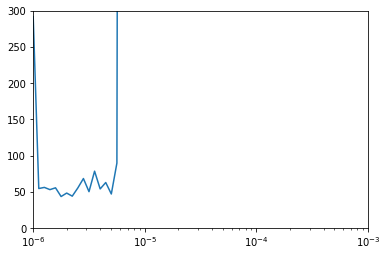

In [113]:
lrs = 1e-6 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 300])

<function matplotlib.pyplot.show>

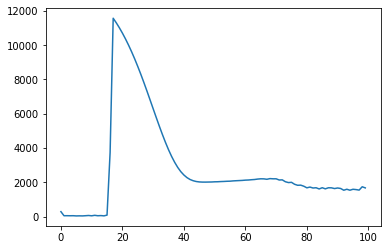

In [114]:
plt.plot(np.arange(100), history.history["loss"])
plt.show

### 2.3 Get Learning Rate with Minimum Loss

In [115]:
index_minloss = np.argmin(history.history["loss"]) # get index of the min loss
index_minloss

5

In [116]:
lrs[index_minloss]

1.7782794100389227e-06

## 2.2 Use chosen learning rate with minimum loss for final model

In [129]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(300, input_shape=[window_size], activation = "relu"),
    tf.keras.layers.Dense(250, activation="relu"),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])


model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-06, momentum=0.9))
history = model.fit(dataset,epochs=100,verbose=0)


# 3 Forecast

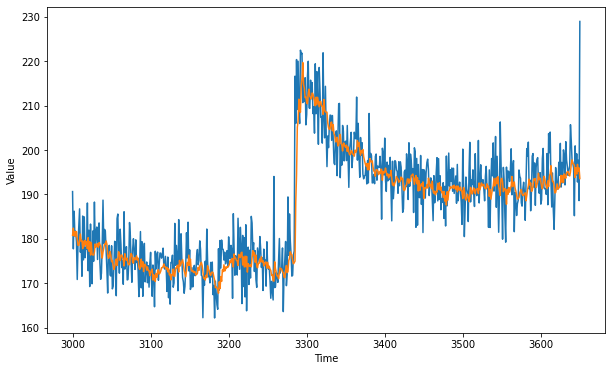

In [130]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# 4 Metric: MAE

In [131]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.47952